-------------------------------------------------
### Overview
- 문제 : 마스크 착용 여부 ( 제대로 썼는지, 대충 썼는지, 안썼는지) 분류
    - 착용 여부 뿐만이 아니라 성별 & 연령대도 분류
- input : 마스크 착용 사진, 미착용 사진, 혹은 이상하게 착용한 사진(코스크, 턱스크) 
- output : 이미지에 맞는 18개의 class (0~17)
- DATA 
    - size : (384, 512)
    - 전체 이미지 폴더 수 : 4500 
    - 한 사람당 이미지의 개수 : 7 [마스크 착용 5장, 이상하게 착용(코스크, 턱스크) 1장, 미착용 1장]
    - train data : 60%
    - 4500 x 7 x 0.6 = 18900 존재
    - 확장자는 jpg  jpeg , png 등 다양
    
    
##### 🧐 마스크 착용 5장 , 이상한 착용 1장 , 미착용 1장에서 data imbalance 문제가 있지 않을까?
--------------------------------------------------

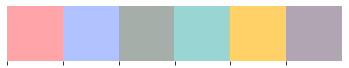

In [10]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import os
import glob
import seaborn as sns

# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline

# unicode minus를 사용하지 않기 위한 설정 (minus 깨짐현상 방지)
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='NanumGothic') # For Windows
# matplotlib 폰트설정


import matplotlib
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()
font_location = 'NanumGothic.ttf' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)


import warnings
warnings.filterwarnings("ignore")

# Set Color Palettes for the notebook
#colors_nude = ['#e0798c','#65365a','#da8886','#cfc4c4','#dfd7ca']
colors_nude = ['#ffa4a9' , '#b0c2ff' , '#a6aea9' , '#99d6d3' , '#ffd166' , '#b1a5b4']
sns.palplot(sns.color_palette(colors_nude))

# Set Style
sns.despine(left=True, bottom=True)

In [11]:
df = pd.read_csv('input/data/train/train.csv')
df.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2700 non-null   object
 1   gender  2700 non-null   object
 2   race    2700 non-null   object
 3   age     2700 non-null   int64 
 4   path    2700 non-null   object
dtypes: int64(1), object(4)
memory usage: 105.6+ KB


-----------------------------------------------------
## <새로운 데이터 프레임 생성>
#### - EDA를 위해 string으로 작성 
- mask : 'Not Wear' , 'Incorrect' , 'Wear'
- age : 'Youth' , 'Mid' , 'Old' 
- path : 절대경로로 추가 
- label : 0 ~ 17
- race : 모두 Asian이기 때문에 drop

#### - 모든 폴더가 7개(5 + 1 + 1)로 채워져있지 않음 
-----------------------------------------------------

In [12]:
# 세 가지 조건에 따른 label 생성 
def make_class(mask, gender , age):
    label =0
    if mask == 'Not Wear' : 
        label += 12        
    elif mask =='Incorrect': 
        label += 6
        
    if gender == 'female' : 
        label += 3
        
    if age == 'Old' : 
        label += 2
    elif age == 'Mid':
        label += 1
    
    return int(label)


def make_mask(mask):
    if mask == 'normal': 
        return 'Not Wear'        
    elif mask =='incorrect_mask': 
        return 'Incorrect'
    else :
        return 'Wear'
    
    
    
def make_ages(age):
    age = int(age)
    if age < 30 :
        return 'Young'
    elif age < 60:
        return 'Mid'
    else : 
        return 'Old'

In [ ]:
mask_df = pd.DataFrame(columns = ['path', 'id' , 'mask' , 'gender' , 'age' , 'label'])
folder_list = glob.glob('input/data/train/images/*')
not_seven_file = []

for folder in folder_list:
    file_list = glob.glob(folder +'/*')
    
    if len(file_list) != 7 :
        not_seven_file.append([folder , len(file_list)])
    
    for file in file_list:    
        mask = make_mask(file.split('.')[0].split('/')[-1])
        idx = file.split('.')[0].split('/')[-2].split('_')[0]
        gender = file.split('.')[0].split('/')[-2].split('_')[1]
        age = make_ages(file.split('.')[0].split('/')[-2].split('_')[3])
        label = make_class(mask, gender, age)
        
        mask_df = mask_df.append({'path' : file , 'id' : idx , 'mask' : mask , 'gender' : gender , 'age' : age ,'label' : int(label) } , ignore_index = True)



In [77]:
mask_df.sort_values(by=['id'], axis=0, inplace = True)
mask_df.reset_index(drop = True, inplace = True)

print(f'7개의 이미지가 모두 들어가있지 않은 폴더의 갯수 : {len(not_seven_file)}')

7개의 이미지가 모두 들어가있지 않은 폴더의 갯수 : 0


In [78]:
mask_df.head()

,path,id,mask,gender,age,label
0,input/data/train/images/000001_female_Asian_45...,000001,Wear,female,Mid,4
1,input/data/train/images/000001_female_Asian_45...,000001,Wear,female,Mid,4
2,input/data/train/images/000001_female_Asian_45...,000001,Wear,female,Mid,4
3,input/data/train/images/000001_female_Asian_45...,000001,Incorrect,female,Mid,10
4,input/data/train/images/000001_female_Asian_45...,000001,Not Wear,female,Mid,16


In [79]:
mask_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18900 entries, 0 to 18899
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    18900 non-null  object
 1   id      18900 non-null  object
 2   mask    18900 non-null  object
 3   gender  18900 non-null  object
 4   age     18900 non-null  object
 5   label   18900 non-null  object
dtypes: object(6)
memory usage: 886.1+ KB


In [80]:
mask_df.describe()

,path,id,mask,gender,age,label
count,18900,18900,18900,18900,18900,18900
unique,18900,2699,3,2,3,18
top,input/data/train/images/001387_female_Asian_21...,003397,Wear,female,Young,4
freq,1,14,13500,11606,8967,4085


--------------------------------------------------------------------
## EDA :조건에 따른 data 분포를 확인
- 기본적으로 이미지 폴더 내 7장의 사진이 존재
- 저 손수건을 쓴 아저씨는 뭘까?; -> 김종호 캠퍼님의 글 참고
- 🧐 test data에는 train data에는 없는 마스크들이 존재 
    - Model이 robust해야하지 않을까?
    - 그러기 위해선 noise를 추가해줘야하나?
--------------------------------------------------------------------

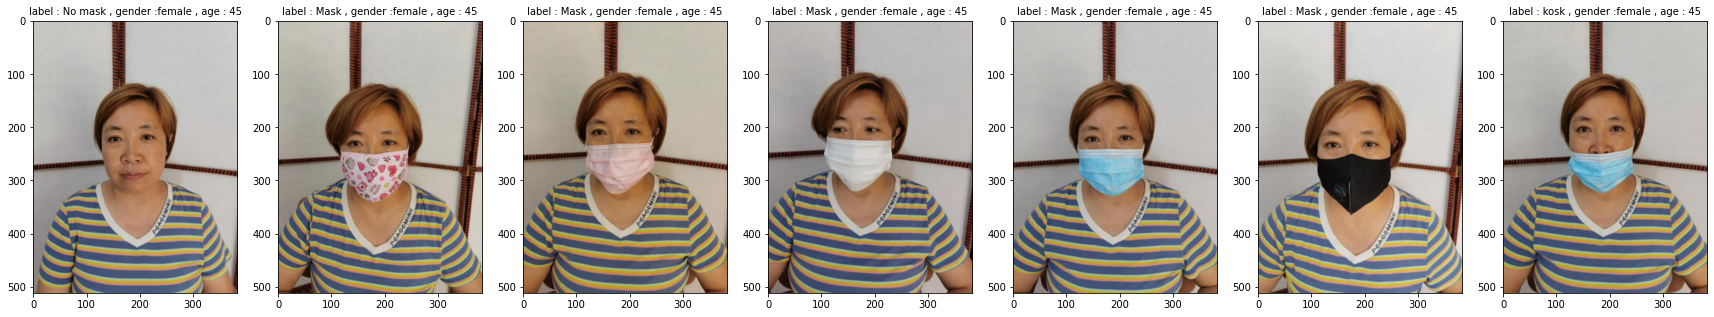

In [81]:
# train 이미지 확인 
fig = plt.figure(figsize = (30,20))
base_path = 'input/data/train/images'
path = os.path.join(base_path , df['path'][0])
file_list = sorted([file for file in os.listdir(path) if file.endswith(".jpg")] , reverse = True)[:7]
for idx , file in enumerate(file_list):
    ax = fig.add_subplot(1,7,idx+1)
    image = Image.open(os.path.join(path, file))
    plt.imshow(image)
    if file.split('.')[0] == 'incorrect_mask' :
        label = 'kosk'
    elif file.split('.')[0] == 'normal':
        label = 'No mask'
    else :
        label = 'Mask'
    gender = df['gender'][0]
    age = df['age'][0]
    ax.set_title(f'label : {label} , gender :{gender} , age : {age}', fontsize = 10)

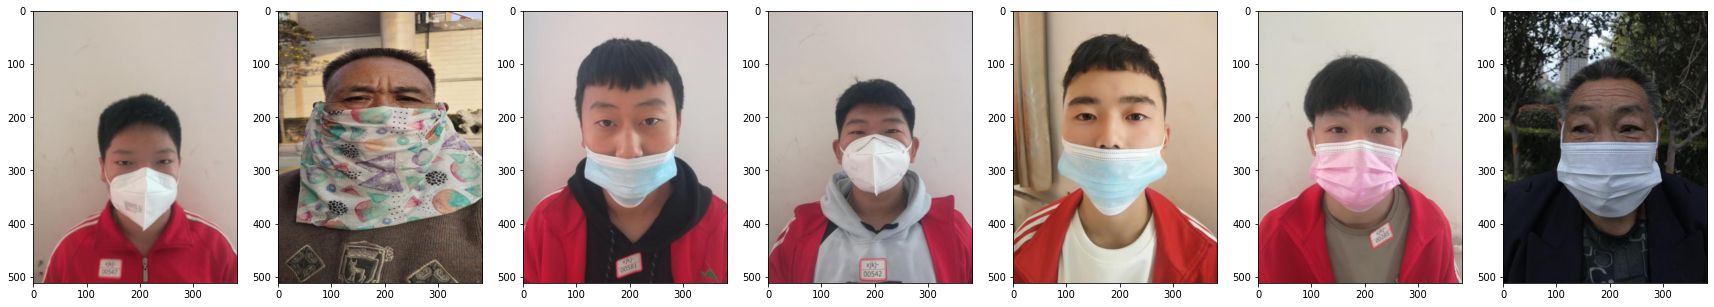

In [82]:
# test image 확인 
test_folder = glob.glob('input/data/eval/images/*.jpg')
fig = plt.figure(figsize = (30,20))
for idx, file in enumerate(test_folder[:7]):
    ax = fig.add_subplot(1,7,idx+1)
    image = Image.open(file)
    plt.imshow(image)

------------------------
#### train data에 대해서 나이 분포 알아보기 
- 특이한 점 : 최대 나이가 60이다. => 노년층은 60살로만 구성 
    - 🧐 노년층에 대한 데이터 부족 우려
------------------------

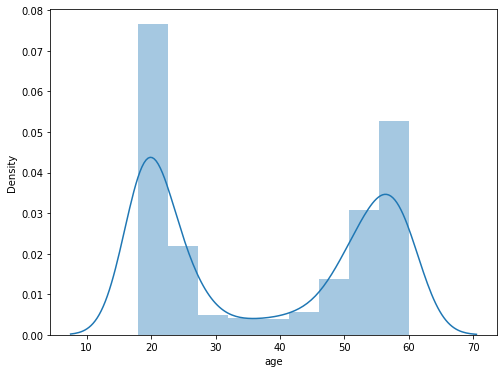

In [83]:
plt.figure(figsize=(8,6))
sns.distplot(df["age"])


----------------------------------
### 변수(age , mask , gender) 별/간 count해보기
- age : 예상대로 청,장년층이 많고 노년층은 대략 1/5 수준 
- gender : 여성의 데이터가 남성의 데이터보다 더 많음 
- mask: 예상대로 마스크를 착용한 경우가 마스크를 착용하지 않거나, 코스크인 경우의 5배수준
- 남성의 경우 청>장>노년 층 순으로 데이터가 많았고, 여성의 경우 장>청>노년 층의 순으로 데이터가 많았다.
- mask 착용 여부는 성별,나이와 관계없이 마스크를 쓴 경우가 안쓰거나 코스크인 경우의 5배 수준 
- 중년 여성 > 청년 여성 > 청년 남성 > 중년 남성 > 노년 여성 > 노년 남성 순으로 데이터가 많음 
- 전체적으로 데이터가 불균형함 
----------------------------------


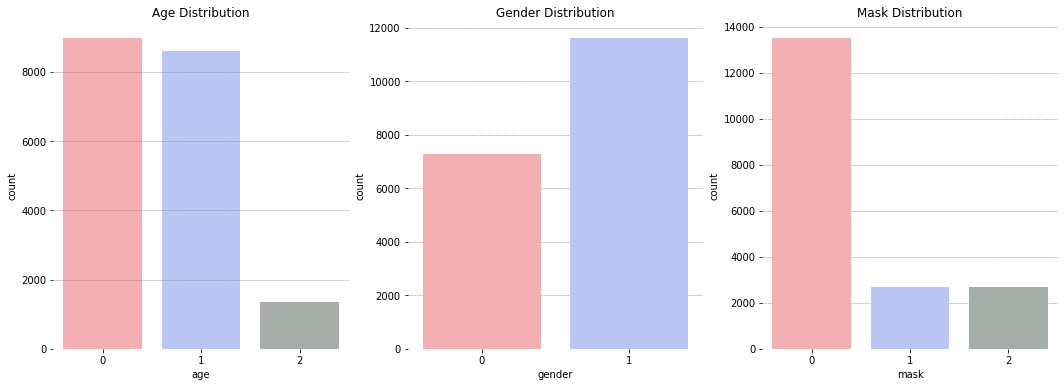

In [91]:
f , (ax1 , ax2 , ax3) = plt.subplots(1,3 , figsize = (18,6))

# AGES variable
age = sns.countplot(mask_df['age'] , ax = ax1 , palette = colors_nude)
ax1.set_title('Age Distribution')

# gender variable
gender = sns.countplot(mask_df['gender'] , ax = ax2 , palette = colors_nude)
ax2.set_title('Gender Distribution')

# Mask variable
mask = sns.countplot(mask_df['mask'] , ax = ax3 , palette = colors_nude)
ax3.set_title('Mask Distribution')

# 보조선 나타내기 
#ax1.set_axisbelow(True)
ax1.yaxis.grid(True, color='gray', linestyle='dashed', linewidth=0.5)

ax2.set_axisbelow(True)
ax2.yaxis.grid(True, color='gray', linestyle='dashed', linewidth=0.5)

ax3.set_axisbelow(True)
ax3.yaxis.grid(True, color='gray', linestyle='dashed', linewidth=0.5)

#테두리 제거
sns.despine(left=True, bottom=True)

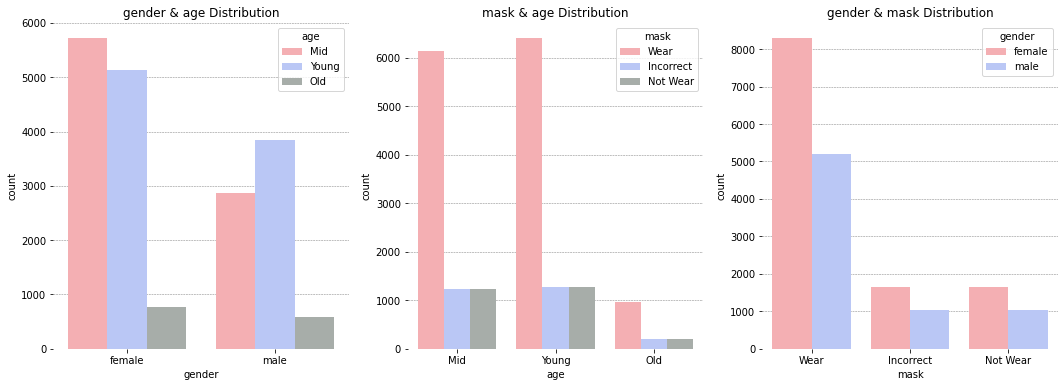

In [85]:
f , (ax1 , ax2 , ax3) = plt.subplots(1,3 , figsize = (18,6))

# AGES & Gender variable
sns.countplot(x="gender", hue="age", data=mask_df , ax = ax1 ,palette = colors_nude)
ax1.set_title('gender & age Distribution')

# AGES & Mask variable
sns.countplot(x="age", hue="mask", data=mask_df , ax = ax2, palette = colors_nude)
ax2.set_title('mask & age Distribution')

# Mask & Gender variable
sns.countplot(x="mask", hue="gender", data=mask_df , ax = ax3 , palette = colors_nude)
ax3.set_title('gender & mask Distribution')

# 보조선 나타내기 
ax1.set_axisbelow(True)
ax1.yaxis.grid(True, color='gray', linestyle='dashed', linewidth=0.5)

ax2.set_axisbelow(True)
ax2.yaxis.grid(True, color='gray', linestyle='dashed', linewidth=0.5)

ax3.set_axisbelow(True)
ax3.yaxis.grid(True, color='gray', linestyle='dashed', linewidth=0.5)

#테두리 제거
sns.despine(left=True, bottom=True)

In [86]:
df_agg = mask_df.groupby(['gender' , 'age' ] , as_index = True).agg('count')
df_agg

path    id  mask  label
gender age                           
female Mid    5719  5719  5719   5719
       Old     763   763   763    763
       Young  5124  5124  5124   5124
male   Mid    2870  2870  2870   2870
       Old     581   581   581    581
       Young  3843  3843  3843   3843

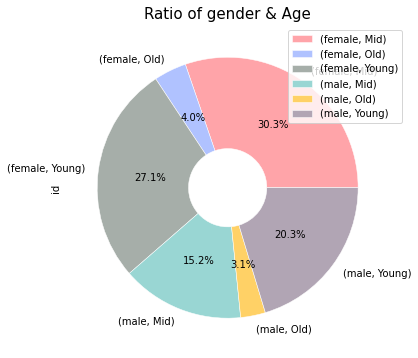

In [92]:
# 부채꼴 영역의 너비, 테두리의 색상 , 테두리 선의 너비 설정
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 0.5}

pie =  df_agg.plot.pie(y='id' , 
                       figsize = (8,6) , 
                       autopct='%1.1f%%' ,
                       colors = ,
                      wedgeprops = wedgeprops)

plt.title('Ratio of gender & Age' , fontsize = 15)
# 범례를 fig 밖으로 뺌
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

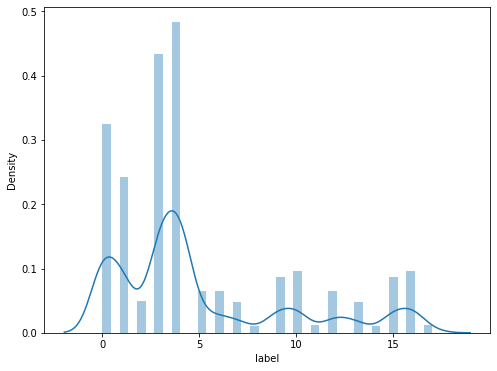

In [93]:
plt.figure(figsize=(8,6))
sns.distplot(mask_df["label"])

In [96]:
mask_df[mask_df['label'] == 4]

,path,id,mask,gender,age,label
0,input/data/train/images/000001_female_Asian_45...,000001,0,1,1,4
1,input/data/train/images/000001_female_Asian_45...,000001,0,1,1,4
2,input/data/train/images/000001_female_Asian_45...,000001,0,1,1,4
5,input/data/train/images/000001_female_Asian_45...,000001,0,1,1,4
6,input/data/train/images/000001_female_Asian_45...,000001,0,1,1,4
...,...,...,...,...,...,...
15729,input/data/train/images/005554_female_Asian_40...,005554,0,1,1,4
15730,input/data/train/images/005554_female_Asian_40...,005554,0,1,1,4
15732,input/data/train/images/005554_female_Asian_40...,005554,0,1,1,4
15733,input/data/train/images/005554_female_Asian_40...,005554,0,1,1,4


In [100]:
mask_df[mask_df['label'] == 14]

,path,id,mask,gender,age,label
2918,input/data/train/images/001038_male_Asian_60/n...,001038,2,0,2,14
2954,input/data/train/images/001043_male_Asian_60/n...,001043,2,0,2,14
2994,input/data/train/images/001047_male_Asian_60/n...,001047,2,0,2,14
3334,input/data/train/images/001101_male_Asian_60/n...,001101,2,0,2,14
3655,input/data/train/images/001152_male_Asian_60/n...,001152,2,0,2,14
...,...,...,...,...,...,...
13916,input/data/train/images/005033_male_Asian_60/n...,005033,2,0,2,14
13989,input/data/train/images/005045_male_Asian_60/n...,005045,2,0,2,14
14090,input/data/train/images/005071_male_Asian_60/n...,005071,2,0,2,14
14978,input/data/train/images/005418_male_Asian_60/n...,005418,2,0,2,14



----------------------------------------------
### EDA가 아닌 모델을 위한 CSV 파일 만들기
- mask, gender, age 바꿔주자
----------------------------------------------

In [88]:
# replace를 이용해 컬럼 내 값을 교체 가능
# age
mask_df['age'].replace(['Young','Mid','Old'],[0,1,2], inplace = True)
# gender
mask_df['gender'].replace(['male' , 'female'] , [0,1] , inplace = True)
# mask
mask_df['mask'].replace(['Wear' , 'Incorrect' , 'Not Wear'] , [0,1,2] , inplace = True)

In [89]:
mask_df.head()

,path,id,mask,gender,age,label
0,input/data/train/images/000001_female_Asian_45...,000001,0,1,1,4
1,input/data/train/images/000001_female_Asian_45...,000001,0,1,1,4
2,input/data/train/images/000001_female_Asian_45...,000001,0,1,1,4
3,input/data/train/images/000001_female_Asian_45...,000001,1,1,1,10
4,input/data/train/images/000001_female_Asian_45...,000001,2,1,1,16


In [90]:
mask_df.to_csv('preprocessing_data.csv')

In [ ]:
## 같이 생각해보면 좋을 것들 
- data imbalance 
    - 수업시간에 배운 focal loss 적용?
    - variable 별 다른 branch 생성?
- robust 
    - noise 추가?
- 얼굴을 다 가렸는데 나이를 어떻게 맞추지?
    - 눈가 주름?
- 머리 길이에 따른 성별 구분? No 
    - 구별할 수 있는 기준이 뭐가 있을까?

In [9]:
# make_csv

In [6]:
origin_df = pd.read_csv('input/data/train/train.csv')
origin_df.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [ ]:
train_df = pd.DataFrame(columns = ['path', 'id' , 'mask' , 'gender' , 'age' , 'label'])
val_df = pd.DataFrame(columns = ['path', 'id' , 'mask' , 'gender' , 'age' , 'label'])
folder_list = glob.glob('input/data/train/images/*')
not_seven_file = []

for folder in folder_list:
    file_list = glob.glob(folder +'/*')
    
    for file in file_list:    
        mask = make_mask(file.split('.')[0].split('/')[-1])
        idx = file.split('.')[0].split('/')[-2].split('_')[0]
        gender = file.split('.')[0].split('/')[-2].split('_')[1]
        age = make_ages(file.split('.')[0].split('/')[-2].split('_')[3])
        label = make_class(mask, gender, age)
        
        mask_df = mask_df.append({'path' : file , 'id' : idx , 'mask' : mask , 'gender' : gender , 'age' : age ,'label' : int(label) } , ignore_index = True)



In [8]:
# 세 가지 조건에 따른 label 생성 
def make_class(mask, gender , age):
    label =0
    if mask == 'Not Wear' : 
        label += 12        
    elif mask =='Incorrect': 
        label += 6
        
    if gender == 'female' : 
        label += 3
        
    if age == 'Old' : 
        label += 2
    elif age == 'Mid':
        label += 1
    
    return int(label)


def make_mask(mask):
    if mask == 'normal': 
        return 'Not Wear'        
    elif mask =='incorrect_mask': 
        return 'Incorrect'
    else :
        return 'Wear'
    
    
    
def make_ages(age):
    age = int(age)
    if age < 30 :
        return 'Young'
    elif age < 60:
        return 'Mid'
    else : 
        return 'Old'